In [1]:
using PyCall, Turing
import PyPlot; plt = PyPlot
;

In [2]:
pymunk, math, sys, random = pyimport.(["pymunk", "math", "sys", "random"])
;

In [3]:
function create_env(g, m, r, pos_0, vel_0)
    space = pymunk.Space()
    space.gravity = (0.0, g)
    mass = m
    radius = r
    inertia = pymunk.moment_for_circle(mass, 0, radius, (0,0))
    body = pymunk.Body(mass, inertia)
    body.position = pos_0[1], pos_0[2]
    body.velocity = vel_0[1], vel_0[2]
    shape = pymunk.Circle(body, radius, (0,0))
    space.add(body, shape)
    return space
end

create_env (generic function with 1 method)

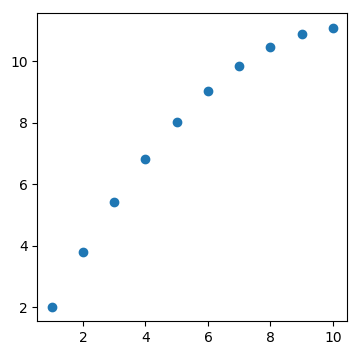

┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[4]:12
└ @ Core ./In[4]:12
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[4]:13
└ @ Core ./In[4]:13


In [4]:
#Simulate observations
space = create_env(-9.8, 1, 25, [0.0,0.0], [10.0, 20.0])
positions_x = []
positions_y = []

#Simulate for N time steps
time_steps = 10
positions = Array{Float64,2}(undef, 2, time_steps)
for i in 1:time_steps
    space.shapes[1].body.apply_force_at_world_point(force=(0.0,-10.0), point=(0,0))#(body.position[1],body.position[2]))
    space.step(1/10)
    append!(positions_x, space.shapes[1].body.position[1])
    append!(positions_y, space.shapes[1].body.position[2])
    positions[:,i] .= space.shapes[1].body.position
end
plt.figure(figsize=(4,4))
plt.scatter(positions_x, positions_y);

In [10]:
@model single_force(pos_list) = begin
    F ~ MvNormal(zeros(2), 10 * ones(2))
    #Define initial params of environment
    space = create_env(-9.8, 1, 25, [0.0,0.0], [10.0, 20.0])
    #Simulate environment
    for i in 1:size(pos_list)[2]
        #Apply force
        space.shapes[1].body.apply_force_at_world_point(force=(F[1],F[2]), point=(0,0))
        #Step simulation
        space.step(1/10)
        #Retrieve updated position
        pos = vec([space.shapes[1].body.position[1], space.shapes[1].body.position[2]])
        pos_list[:,i] ~ MvNormal(pos, 0.1)
    end
end
chain = sample(single_force(positions), PG(100), 500)

┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = macro expansion at In[10]:12 [inlined]
└ @ Core ./In[10]:12
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = macro expansion at In[10]:12 [inlined]
└ @ Core ./In[10]:12
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = macro expansion at In[10]:12 [inlined]
└ @ Core ./In[10]:12
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = macro expansion at In[10]:12 [inlined]
└ @ Core ./In[10]:12
Progress: 100%|█████████████████████████████████████████| Time: 0:04:52


Object of type Chains, with data of type 500×5×1 Array{Float64,3}

Log evidence      = -9.210782429641798e9
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = le, lp, weight
parameters        = F[1], F[2]

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std         │ naive_se    │ mcse    │ ess     │
│     │ Symbol     │ Float64  │ Float64     │ Float64     │ Float64 │ Any     │
├─────┼────────────┼──────────┼─────────────┼─────────────┼─────────┼─────────┤
│ 1   │ F[1]       │ 6.5585   │ 4.44534e-15 │ 1.98802e-16 │ 0.0     │ 2.00803 │
│ 2   │ F[2]       │ -16.6673 │ 3.55627e-15 │ 1.59041e-16 │ 0.0     │ 2.00803 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1  